In [1]:
import pandas as pd
import numpy as np
import sys
import torch
sys.path.append("/home/chenlidong/polyAttn")
sys.path.append("/home/chenlidong/polymer-chemprop-master/chemprop")
from features import mol2graph
import os
from sklearn.model_selection import train_test_split
from torch_geometric.data import Dataset, download_url, Data
from torch_geometric.nn.models import GAT

/home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_spline_conv/_basis_cuda.so)
  warnings.warn(


读取Cache文件


In [2]:
# import pandas as pd

# # 读取原始CSV文件
# df = pd.read_csv("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/master/dataset-master_chemprop.csv")

# # 将行索引保存为名为"idx"的列
# df.insert(0, "idx", df.index)
# type_column = [0] * 18414 + [1] * 12276 + [2] * 12276

# df['type'] = type_column
# # 保存带有新列的CSV文件
# df.to_csv("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/master/dataset-master_chemprop.csv", index=False)  # 设置index=False以避免保存索引列


ValueError: cannot insert idx, already exists

In [51]:
df.iloc[18413+12276:18416+12276,:]

,idx,master_chemprop_input,EA vs SHE (eV),IP vs SHE (eV),type
30689,30689,O=S1(=O)c2ccccc2-c2ccccc21.Nc1ccccc1,-2.450132,1.412885,1
30690,30690,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,-3.164844,1.781074,2
30691,30691,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,-3.348407,1.717210,2


In [43]:
12276 + 12276 + 18414

42966

In [127]:
copolymer_data = pd.read_csv("/home/chenlidong/polyAttn/data/copolymer/copolymer.csv")

In [128]:
seeds = [6,10,18,24,42]
for seed in seeds:
    train_df, remaining_df = train_test_split(copolymer_data, test_size=0.4, random_state=24)
    valid_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=24)
    dfs = [train_df,valid_df,test_df]
    phases = ["train","val","test"]
    for df,phase in zip(dfs,phases):
        batch_mol2graph = mol2graph(df.SMILES.to_list())
        f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _  = batch_mol2graph.get_components()
        a2a = batch_mol2graph.get_a2a()
        b2b = batch_mol2graph.get_b2b()
        ea = torch.tensor(df.Ea.to_list(),dtype=torch.float32)
        ip = torch.tensor(df.IP.to_list(),dtype=torch.float32)
        dataset = []

        for idx,(a_scope_i,b_scope_i) in enumerate(zip(a_scope,b_scope)):
            edge_index = [[],[]]
            b2a_i = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
            b2revb_i = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]

            for i in range(b2a_i.size(0)):
                edge_index[0].append(b2a_i[i].item()-a_scope_i[0])
                edge_index[1].append(b2a_i[b2revb_i[i]-b_scope_i[0]]-a_scope_i[0])

            data = Data(
                x = f_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
                edge_index=torch.tensor(edge_index,dtype=torch.long),
                edge_attr = f_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
                w_atoms = w_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
                w_bonds = w_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
                # a2b = a2b[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
                # b2a = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
                b2revb = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]] - 1,
                # a2a = a2a[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
                # b2b = b2b[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
                ea = ea[idx],
                ip = ip[idx]
            )
            dataset.append(data)
        torch.save(dataset,f"/home/chenlidong/polyAttn/preprocessed/copolymer_4w/stochastic/{seed}/{phase}.pt")
        print(f"seed {seed} of {phase} has been preprocessed, length: {len(dataset)}")

seed 6 of train has been preprocessed, length: 25779
seed 6 of val has been preprocessed, length: 8593
seed 6 of test has been preprocessed, length: 8594
seed 10 of train has been preprocessed, length: 25779
seed 10 of val has been preprocessed, length: 8593
seed 10 of test has been preprocessed, length: 8594
seed 18 of train has been preprocessed, length: 25779
seed 18 of val has been preprocessed, length: 8593
seed 18 of test has been preprocessed, length: 8594
seed 24 of train has been preprocessed, length: 25779
seed 24 of val has been preprocessed, length: 8593
seed 24 of test has been preprocessed, length: 8594
seed 42 of train has been preprocessed, length: 25779
seed 42 of val has been preprocessed, length: 8593
seed 42 of test has been preprocessed, length: 8594


In [97]:
train_df, remaining_df = train_test_split(copolymer_data, test_size=0.4, random_state=6)
valid_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=6)

# print("训练集大小:", len(train_df))
# print("验证集大小:", len(valid_df))
# print("测试集大小:", len(test_df))

In [99]:
test_df.iloc[0,:].SMILES

'[*:1]c1ccc([*:2])c2nsnc12.[*:3]c1cc([*:4])nc(OC)c1N|0.25|0.75|<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.25:0.25<3-4:0.25:0.25<1-1:0.25:0.25<2-2:0.25:0.25<3-3:0.25:0.25<4-4:0.25:0.25'

In [72]:
batch_mol2graph = mol2graph(valid_df.SMILES.to_list())
f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _  = batch_mol2graph.get_components()

In [73]:
a2a = batch_mol2graph.get_a2a()
b2b = batch_mol2graph.get_b2b()
ea = torch.tensor(valid_df.Ea.to_list(),dtype=torch.float32)
ip = torch.tensor(valid_df.IP.to_list(),dtype=torch.float32)

In [74]:
dataset = []

for idx,(a_scope_i,b_scope_i) in enumerate(zip(a_scope,b_scope)):
    edge_index = [[],[]]
    b2a_i = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    b2revb_i = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]

    for i in range(b2a_i.size(0)):
        edge_index[0].append(b2a_i[i].item()-a_scope_i[0])
        edge_index[1].append(b2a_i[b2revb_i[i]-b_scope_i[0]]-a_scope_i[0])

    data = Data(
        x = f_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
        edge_index=torch.tensor(edge_index,dtype=torch.long),
        edge_attr = f_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
        w_atoms = w_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
        w_bonds = w_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
        # a2b = a2b[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
        # b2a = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
        # b2revb = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
        # a2a = a2a[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
        # b2b = b2b[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]],
        ea = ea[idx],
        ip = ip[idx]
    )
    dataset.append(data)

In [75]:
len(dataset)

8593

In [76]:
torch.save(dataset,"/home/chenlidong/polyAttn/preprocessed/copolymer_4w/stochastic/24/val.pt")

In [92]:
class PolymerDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, phase="train", atom_messages=False):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.root = root
        self.phase = phase
        self.atom_messages = atom_messages
        self.dataset = []
        self.tensor2data()

    @property
    def raw_file_names(self):
        if self.phase == "train":
            return [os.path.join(self.root, "train.pt")]
        elif self.phase == "val":
            return [os.path.join(self.root, "val.pt")]
        elif self.phase == "test":
            return [os.path.join(self.root, "test.pt")]
        else:
            raise ValueError("phase must be in [train, val, test]")

    @property
    def processed_file_names(self):
        return self.dataset
        
    def tensor2data(self):
        # Todo
        # add atom_message information
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            self.dataset = torch.load(raw_path)

    def get(self,idx):
        return self.dataset[idx]
    
    def len(self):
        return len(self.dataset)

In [93]:
a = PolymerDataset("/home/chenlidong/polyAttn/preprocessed/copolymer_4w/stochastic/6/",phase="test")

In [94]:
a.len()

8594

In [96]:
a[0].b2revb

tensor([ 2,  1,  4,  3,  6,  5,  8,  7, 10,  9, 12, 11, 14, 13, 16, 15, 18, 17,
        20, 19, 22, 21, 24, 23, 26, 25, 28, 27, 30, 29, 32, 31, 34, 33, 36, 35,
        38, 37, 40, 39])

In [3]:
a = mol2graph(['[*:1]c1ccc([*:2])c2nsnc12.[*:3]c1cc([*:4])nc(OC)c1N|0.25|0.75|<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.25:0.25<3-4:0.25:0.25<1-1:0.25:0.25<2-2:0.25:0.25<3-3:0.25:0.25<4-4:0.25:0.25'])

In [4]:
f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _ = a.get_components()

In [5]:
f_atoms.shape

torch.Size([19, 133])

In [59]:
w_atoms = torch.tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000])
b2a = torch.tensor([ 0,  1,  1,  2,  1,  7,  2,  3,  3,  4,  4,  5,  4,  6,  6,  7,  8,  9,
         9, 10,  9, 16, 10, 11, 11, 12, 11, 13, 13, 14, 14, 15, 14, 16])+1
b2revb = torch.tensor([ 2,  1,  4,  3,  6,  5,  8,  7, 10,  9, 12, 11, 14, 13, 16, 15, 18, 17,
        20, 19, 22, 21, 24, 23, 26, 25, 28, 27, 30, 29, 32, 31, 34, 33])-1
w_bonds = torch.tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

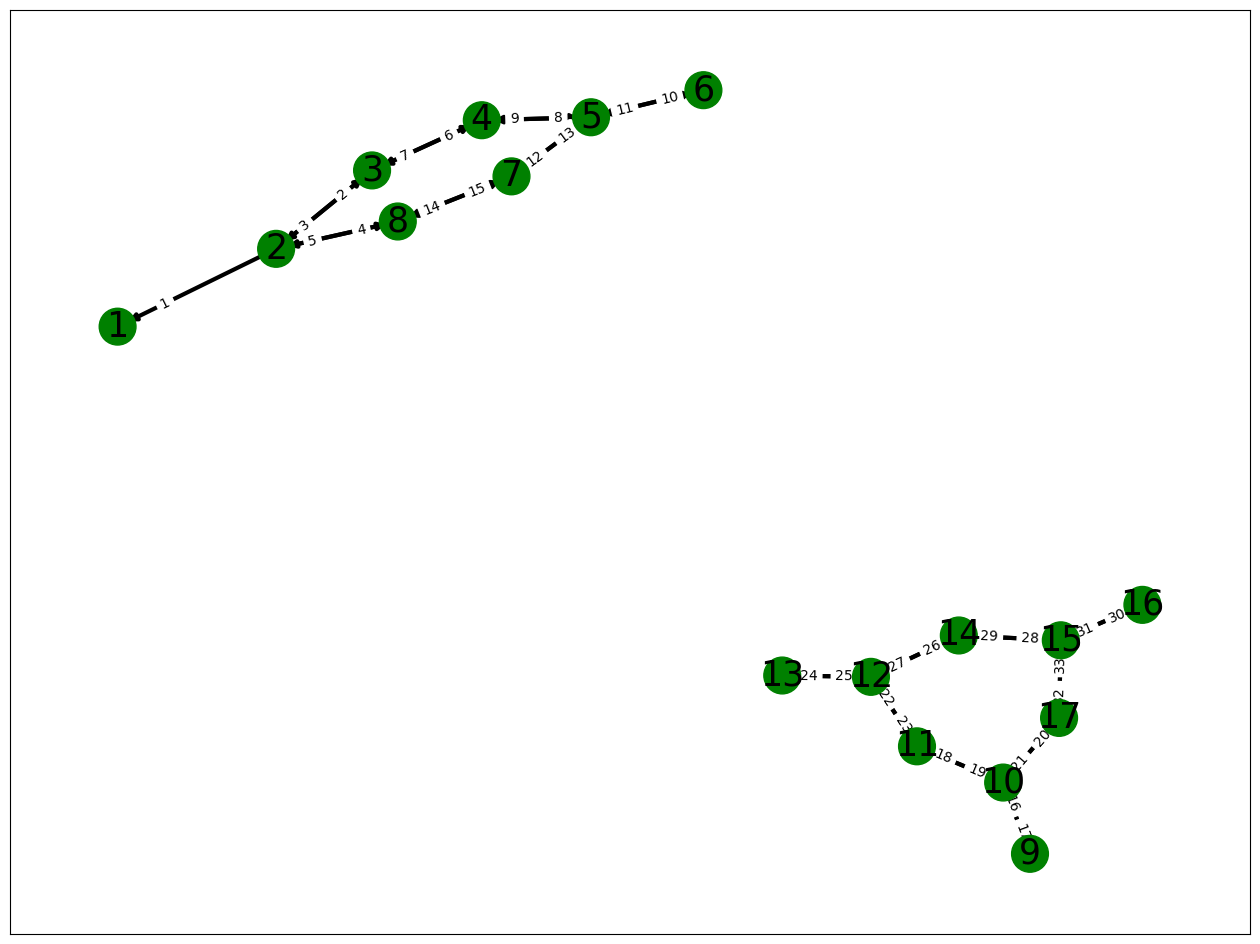

In [60]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
# 创建一个空的无向图
G = nx.DiGraph()

for i in range(1,w_atoms.shape[0]+1):
    G.add_node(i, label=w_atoms[i-1])

for i in range(1,b2a.size(0)):
    G.add_edge(b2a[i].item(),b2a[b2revb[i]].item(),color= "black" if w_bonds[i].item() == 1.0 else "grey",label=str(i))

pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')
node_colors = ["red" if G.nodes[node]['label'] == 0.25 else "green"  for node in G.nodes]
edge_colors = [G.edges[edge]['color'] for edge in G.edges]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=3, edge_color=[G[u][v]["color"] for u, v in G.edges()], arrows=True)
nx.draw_networkx_labels(G, pos, font_size=25, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, edge_labels,font_size=10, font_color='black', label_pos=0.3)

plt.show()

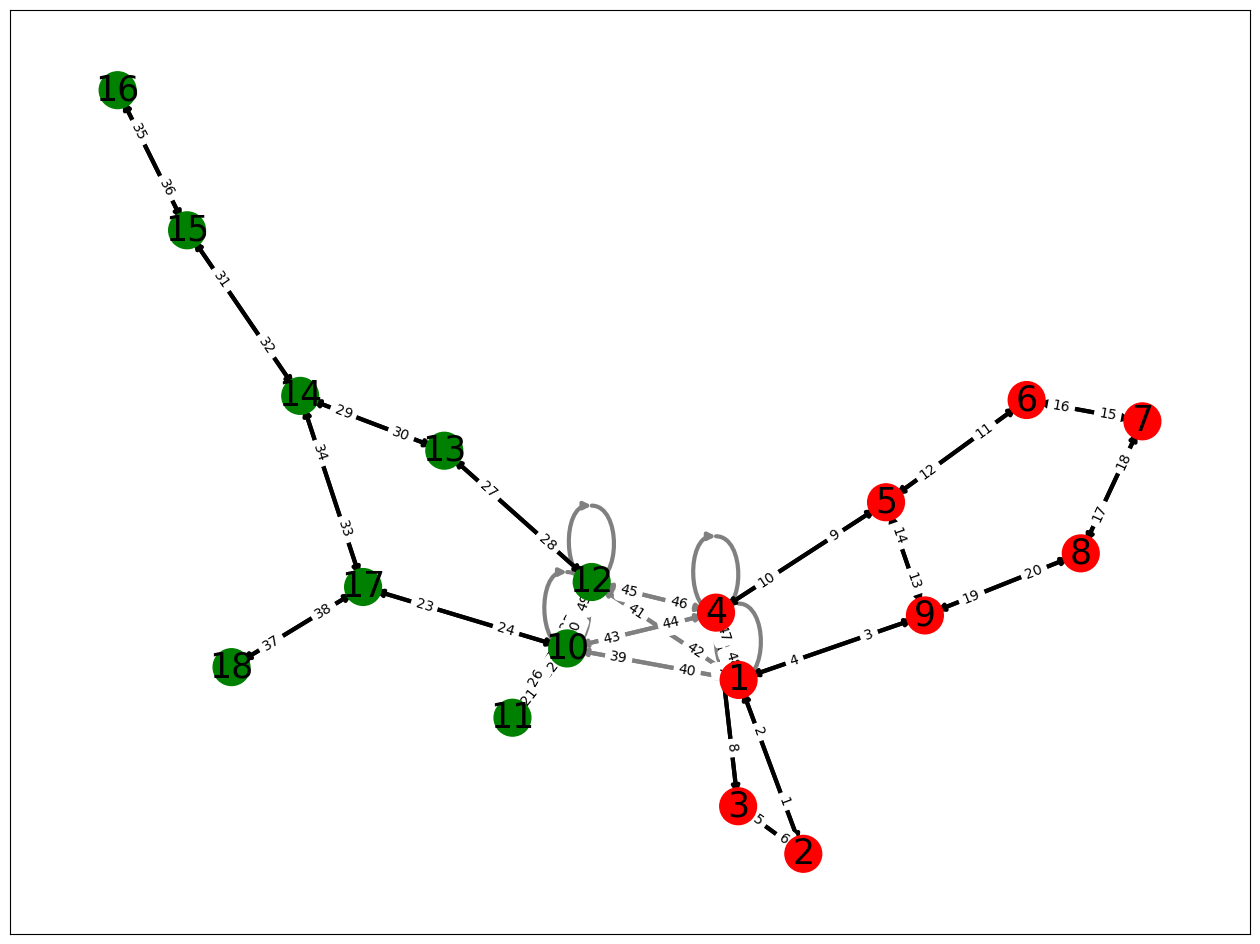

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
# 创建一个空的无向图
G = nx.DiGraph()

for i in range(1,19):
    G.add_node(i, label=a.get_components()[2][i].item())

for i in range(1,a.get_components()[5].size(0)):
    G.add_edge(a.get_components()[5][i].item(),a.get_components()[5][a.get_components()[6][i]].item(),color= "black" if a.get_components()[3][i].item() == 1.0 else "grey",label=str(i))

pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')
node_colors = ["red" if G.nodes[node]['label'] == 0.25 else "green"  for node in G.nodes]
edge_colors = [G.edges[edge]['color'] for edge in G.edges]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=3, edge_color=[G[u][v]["color"] for u, v in G.edges()], arrows=True)
nx.draw_networkx_labels(G, pos, font_size=25, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, edge_labels,font_size=10, font_color='black', label_pos=0.3)

plt.show()

In [55]:
# batch_mol2graph = mol2graph(test_df.iloc[0:2,:].SMILES.to_list())
batch_mol2graph = a
f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _  = batch_mol2graph.get_components()
a2a = batch_mol2graph.get_a2a()
b2b = batch_mol2graph.get_b2b()
ea = torch.tensor(test_df.iloc[0:2,:].Ea.to_list(),dtype=torch.float32)
ip = torch.tensor(test_df.iloc[0:2,:].IP.to_list(),dtype=torch.float32)

In [55]:
from torch_geometric.loader import DataLoader
loader = DataLoader(a.dataset, batch_size=64, shuffle=False)

In [56]:
import sys
sys.path.append("/home/chenlidong/polyAttn/models")
from polygnn import polygnn
import torch.nn as nn

In [64]:
hps ={
    "ffn_capacity" : 1,
    "depth":1,
    "readout_dim": 128,
    "activation": nn.functional.mse_loss
}

In [58]:
import random
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [59]:
model = polygnn(133,147,hps)

In [106]:
for batch in loader:
    print(batch['ea'])
    break

tensor([1.6579, 3.6785, 3.3072, 2.9175, 1.9693, 3.1040, 2.2334, 2.7352, 2.7080,
        2.3227, 2.1719, 2.9156, 1.3587, 2.2566, 2.5441, 3.4482, 3.8133, 2.8296,
        2.8344, 2.3813, 3.0515, 2.7431, 2.4418, 2.8919, 3.0741, 3.0356, 2.7336,
        2.9680, 2.6360, 5.9623, 2.5324, 2.3042, 3.5594, 3.9729, 2.5042, 2.0755,
        2.7017, 2.5687, 3.0823, 2.9598, 2.4163, 3.4576, 3.3788, 2.9512, 3.6975,
        1.7717, 2.6672, 2.0202, 2.6074, 2.0575, 2.7714, 2.9822, 3.9756, 2.5316,
        2.0150, 3.9958, 2.2262, 2.6943, 1.6934, 3.0879, 3.3117, 2.6725, 3.8456,
        2.4339])


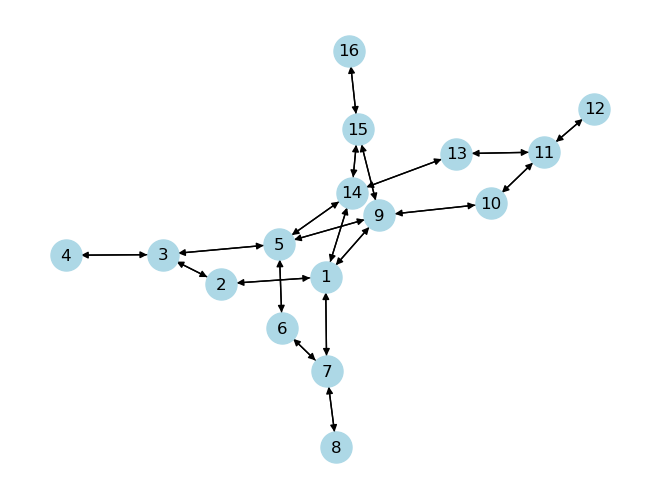

In [125]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
data = dataset[0]
G = to_networkx(data, to_undirected=False)
# 获取节点特征
node_labels = {i: i+1 for i in range(data.num_nodes)}

# 绘制图形
pos = nx.spring_layout(G)  # 选择一种布局算法
nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='lightblue', node_size=500)
plt.show()

# 以下代码为保存coponents代码

In [ ]:
import pandas as pd
import numpy as np
import sys
import torch
sys.path.append("/home/chenlidong/polyAttn")
sys.path.append("/home/chenlidong/polymer-chemprop-master/chemprop")
from features import mol2graph
import os
from chemprop.data.data import MoleculeDataset
from sklearn.model_selection import train_test_split
from torch_geometric.data import Dataset, download_url, Data
from torch_geometric.nn.models import GAT
from chemprop.data import get_data
import pandas as pd
from chemprop.args import TrainArgs

/home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_spline_conv/_basis_cuda.so)
  warnings.warn(


In [5]:
args = TrainArgs()
args.data_path ="/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/Egc.csv",
args.dataset_type = "regression"
args.aggregation = "mean"
args.polymer = False

In [6]:
data = get_data(
    path=args.data_path[0],
    args=args,
    skip_none_targets=True,
)

3380it [00:00, 138346.17it/s]
100%|██████████| 3380/3380 [00:00<00:00, 61252.41it/s]


In [7]:
batch = data.batch_graph()

3677


In [6]:
import pickle
SMILES_TO_GRAPH = pickle.load(open('/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/master/4w_copolymer.pkl', 'rb'))

In [10]:
SMILES_TO_GRAPH['OB(O)c1cc(F)c(B(O)O)cc1F.Oc1cc(O)c(Br)c(O)c1Br00'].distance

tensor([[  0,   1,   2,  ..., 100, 100, 100],
        [  1,   0,   1,  ..., 100, 100, 100],
        [  2,   1,   0,  ..., 100, 100, 100],
        ...,
        [100, 100, 100,  ..., 100, 100, 100],
        [100, 100, 100,  ..., 100, 100, 100],
        [100, 100, 100,  ..., 100, 100, 100]])

In [34]:
import math
def get_sin_encodings(rel_pos_buckets, model_dim) -> torch.Tensor:
    pe = torch.zeros(rel_pos_buckets + 1, model_dim)
    position = torch.arange(-2, rel_pos_buckets-2).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, model_dim, 2, dtype=torch.float) *
                          -(math.log(10000.0) / model_dim)))
    pe[:-1, 0::2] = torch.sin(position.float() * div_term)          # leaving last "position" as padding
    pe[:-1, 1::2] = torch.cos(position.float() * div_term)

    return pe

In [35]:
distance = torch.load("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/master/distance.pt")

In [36]:
relative_pe = torch.nn.Embedding.from_pretrained(
    embeddings=get_sin_encodings(200, 300),
    freeze=True,
    padding_idx=-1
)

In [37]:
relative_pe(distance)

IndexError: index out of range in self